<h2 style='color:blue' align='center'>Data Augmentation To Address Overfitting In Flower Classification CNN</h2>

**In this notebook we will build a CNN to classify flower images. We will also see how our model overfits and how overfitting can be addressed using data augmentation. Data augmentation is a process of generating new training samples from current training dataset using transformations such as zoom, rotations, change in contrast etc**

Credits: I used tensorflow offical tutorial: https://www.tensorflow.org/tutorials/images/classification as a reference and made bunch of changes to make it simpler

In below image, 4 new training samples are generated from original sample using different transformations

<img src="daisy2.JPG" />

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2025-03-20 00:59:54.165063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742403594.183501  452059 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742403594.190140  452059 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742403594.204761  452059 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742403594.204780  452059 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742403594.204781  452059 computation_placer.cc:177] computation placer alr

We will download flowers dataset from google website and store it locally. In below call it downloads the zip file (.tgz) in cache_dir which is . meaning the current folder

<h3 style='color:purple'>Load flowers dataset</h3>

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


In [5]:
data_dir

'./datasets/flower_photos'

In [6]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [7]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/roses/14810868100_87eb739f26_m.jpg'),
 PosixPath('datasets/flower_photos/roses/1446090416_f0cad5fde4.jpg'),
 PosixPath('datasets/flower_photos/roses/15319767030_e6c5602a77_m.jpg'),
 PosixPath('datasets/flower_photos/roses/15032112248_30c5284e54_n.jpg'),
 PosixPath('datasets/flower_photos/roses/7211616670_2d49ecb3a5_m.jpg')]

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [9]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/14810868100_87eb739f26_m.jpg'),
 PosixPath('datasets/flower_photos/roses/1446090416_f0cad5fde4.jpg'),
 PosixPath('datasets/flower_photos/roses/15319767030_e6c5602a77_m.jpg'),
 PosixPath('datasets/flower_photos/roses/15032112248_30c5284e54_n.jpg'),
 PosixPath('datasets/flower_photos/roses/7211616670_2d49ecb3a5_m.jpg')]

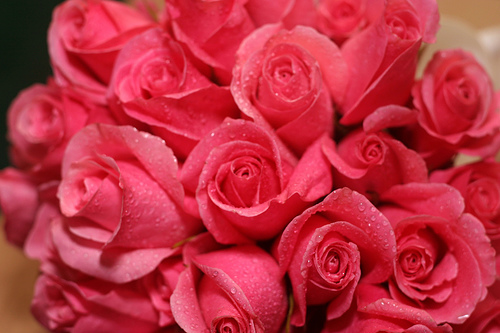

In [10]:
PIL.Image.open(str(roses[1]))

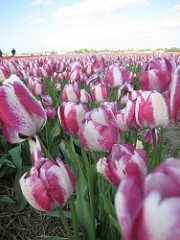

In [11]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [13]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [14]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [15]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/14810868100_87eb739f26_m.jpg'),
 PosixPath('datasets/flower_photos/roses/1446090416_f0cad5fde4.jpg'),
 PosixPath('datasets/flower_photos/roses/15319767030_e6c5602a77_m.jpg'),
 PosixPath('datasets/flower_photos/roses/15032112248_30c5284e54_n.jpg'),
 PosixPath('datasets/flower_photos/roses/7211616670_2d49ecb3a5_m.jpg')]

In [16]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/14810868100_87eb739f26_m.jpg'

In [17]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [18]:
img.shape

(240, 178, 3)

In [19]:
cv2.resize(img,(180,180)).shape

(180, 180, 3)

In [20]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [21]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [24]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

<h3 style='color:purple'>Build convolutional neural network and train it</h3>

In [25]:
num_classes = 5

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
             

I0000 00:00:1742403713.939185  452059 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1918 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [26]:
model.fit(X_train_scaled, y_train, epochs=30) 

2025-03-20 01:02:04.222050: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1069977600 exceeds 10% of free system memory.
2025-03-20 01:02:05.108823: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1069977600 exceeds 10% of free system memory.


Epoch 1/30


I0000 00:00:1742403727.227044  454985 service.cc:152] XLA service 0x7aeef415a250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742403727.227087  454985 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-03-20 01:02:07.313861: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742403727.576658  454985 cuda_dnn.cc:529] Loaded cuDNN version 90800


 6/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2629 - loss: 2.4978

I0000 00:00:1742403732.139036  454985 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.3145 - loss: 1.6795
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5639 - loss: 1.0766
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6680 - loss: 0.8610
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7646 - loss: 0.6377
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8504 - loss: 0.4238
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9078 - loss: 0.2779
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9546 - loss: 0.1593
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9652 - loss: 0.1134
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9817 - loss: 0.0656
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9901 - loss: 0.0386
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9815 - loss: 0.0675
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9990 - l

In [27]:
model.evaluate(X_test_scaled,y_test)

2025-03-20 01:03:29.226478: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 356918400 exceeds 10% of free system memory.
2025-03-20 01:03:29.517868: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 356918400 exceeds 10% of free system memory.


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6651 - loss: 2.7179

2025-03-20 01:03:31.483564: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_82', 4 bytes spill stores, 4 bytes spill loads



29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6646 - loss: 2.7232


[2.797774076461792, 0.656862735748291]

**Here we see that while train accuracy is very high (99%), the test accuracy is significantly low (66.99%) indicating overfitting. Let's make some predictions before we use data augmentation to address overfitting**

In [28]:
predictions = model.predict(X_test_scaled)
predictions

2025-03-20 01:03:36.782551: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 356918400 exceeds 10% of free system memory.


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


array([[ 15.160458  ,  29.854698  , -25.62888   ,  -6.6279793 ,
         22.939413  ],
       [ 38.387737  ,  -1.7924113 , -36.629856  , -22.002758  ,
         32.72786   ],
       [ -2.0766835 ,   0.94040203,   6.4700327 ,  -5.145681  ,
          2.489604  ],
       ...,
       [ -6.773423  , -20.760944  ,  -4.485527  ,  29.962296  ,
          5.058148  ],
       [  4.0856967 ,  13.555813  ,   6.249349  , -14.569342  ,
          1.727011  ],
       [ -1.0565528 , -14.6521845 ,   0.56203526,  15.372325  ,
          7.6654987 ]], dtype=float32)

In [29]:
score = tf.nn.softmax(predictions[0])

In [30]:
np.argmax(score)

np.int64(1)

In [31]:
y_test[0]

np.int64(1)

<h3 style='color:purple'>Improve Test Accuracy Using Data Augmentation</h3>

In [37]:
img_height = 180
img_width = 180
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/home/kuugang/Documents/3rd Year/2ndSem/IS2/.env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Original Image**

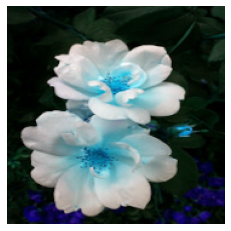

In [370]:
plt.axis('off')
plt.imshow(X[0])

**Newly generated training sample using data augmentation**

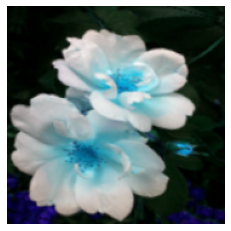

In [371]:
plt.axis('off')
plt.imshow(data_augmentation(X)[0].numpy().astype("uint8"))

<h3 style='color:purple'>Train the model using data augmentation and a drop out layer</h3>

In [38]:
num_classes = 5

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)    

Epoch 1/30


E0000 00:00:1742404031.684462  452059 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 3/86 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1927 - loss: 2.2436

2025-03-20 01:07:13.948364: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 460.80MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.3204 - loss: 1.6000
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5540 - loss: 1.0831
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5986 - loss: 1.0120
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6616 - loss: 0.8785
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6788 - loss: 0.8433
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6810 - loss: 0.8223
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6818 - loss: 0.7727
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7110 - loss: 0.7231
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7292 - loss: 0.7204
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7565 - loss: 0.6535
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7475 - loss: 0.6546
Epoch 12/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7600 - l

In [39]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7466 - loss: 0.9794


[0.9755122065544128, 0.7374727725982666]

**You can see that by using data augmentation and drop out layer the accuracy of test set predictions is increased to 73.74%**